In [1]:
from z3 import *
import numpy as np
import re
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()

import os, sys
sys.path.append(os.path.join("../../../"))

from src.mcmc_sat import smt, mcmc, sat, utils

In [2]:
south_head = pd.read_csv("south_head.csv")
south_head

,,0-4 years,5-9 years,10-14 years,15-19 years,20-24 years,25-29 years,30-34 years,35-39 years,40-44 years,45-49 years,50-54 years,55-59 years,60-64 years,65-69 years,70-74 years,75-79 years,80-84 years,85-89 years,90 years and over
0,Male,3,6,6,12,9,3,9,9,6,6,15,6,3,6,3,3,0,0,0
1,Female,6,0,3,6,3,6,3,9,3,6,9,6,9,3,3,3,0,0,0
2,Total,15,3,12,15,15,12,9,18,9,12,21,12,12,12,6,0,0,0,0


In [3]:
# Assumption, all bit-vectors are of the same size
num_bits = 5
num_vars = 19*2
var_list = [BitVec(f'x{i}',num_bits) for i in range(num_vars)]
x = var_list
g = Goal()
sat.add_bool_vars_to_goal(g, var_list)

#Add contraints
numpy_data = south_head.to_numpy()[:,1:]

for i in range(19):
    g.add(ULE(x[i],numpy_data[0,i]+2))
    if(numpy_data[0,i]>0):
        g.add(ULE(numpy_data[0,i]-2,x[i]))

    g.add(ULE(x[i+19],numpy_data[1,i]+2))
    if(numpy_data[1,i]>0):
        g.add(ULE(numpy_data[1,i]-2,x[i+19]))

    g.add(ULE(x[i+19] + x[i], numpy_data[2,i]+2))
    if(numpy_data[2,i]>0):
        g.add(ULE(numpy_data[2,i]-2,x[i+19]+x[i]))

In [4]:
trace = mcmc.sample_mh_trace_from_z3_model(backend='spur',
                                           z3_problem=g,
                                           num_vars=num_vars,
                                           num_bits=num_bits,
                                           num_samples=10000, 
                                           num_chains=4)

Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	661/661/0
independent support size:  	0
clauses (all/long/binary/unit): 2025/1183/754/88
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	1722 MB

STAGE #1: Build the initial partial assignments


STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	1722 MB

Completing sample #1 of 2 which has 3 variables unset and 1055 samples.
Sample #2 of 2 is already a complete assignment.  Continuing...
STAGE #2 - COMPLETE


variables (total / active / free)	661/661/0
clauses (removed) 		2025 (0)
decisions 				188
conflicts 				1
conflict clauses (all/bin/unit) 	28/17/88
failed literals found by implicit BCP 	 26
implicit BCP miss rate 	97.5836%
bytes cache size     	20250568	
bytes cache (overall) 	20250568
bytes cache (infra / comps) 20234408/16160	
bytes pure comp data (curr)    4016
bytes pure comp data (overall) 4016
bytes cache with sysoverh (curr)    27792
bytes cache with sysoverh (overall) 27792
cache (stores / hits) 			190/1
cache miss rate 		99.4709%
avg. variable count (stores / hits) 	16.6368/3


# solutions 
304857308880000000

# END

time

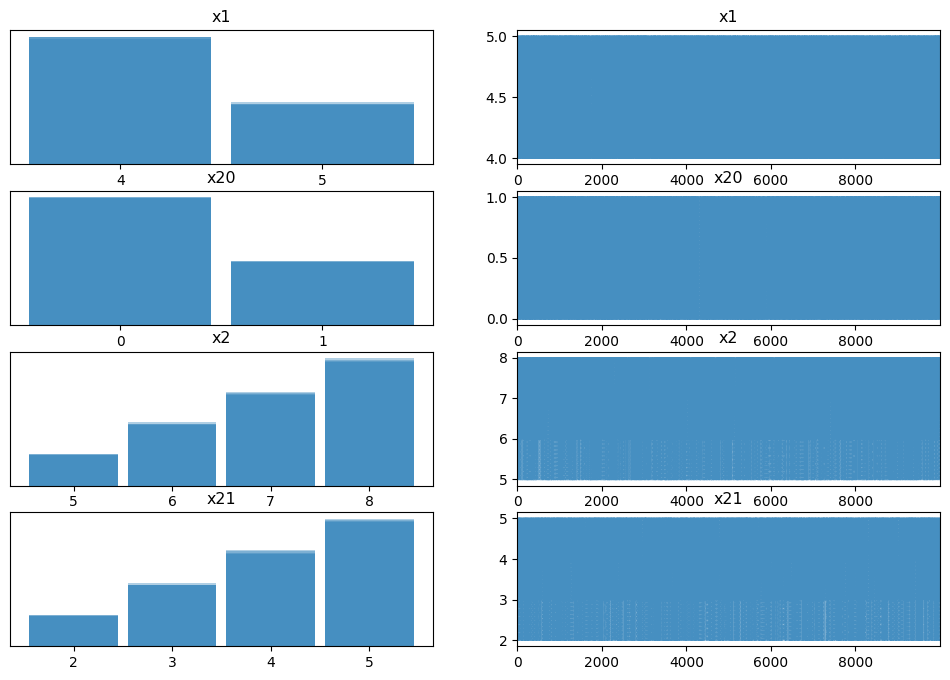

In [5]:
# Plot the posterior
az.plot_trace(trace, var_names=['x1', 'x20', 'x2', 'x21']);
plt.savefig('spur_trace_plot_nz_db.png', dpi=150);

In [6]:
# Diagnostics
az.summary(trace)

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,5.000,0.000,5.0,5.0,0.000,0.000,40000.0,40000.0,NaN
x1,4.323,0.467,4.0,5.0,0.002,0.002,39174.0,39174.0,1.0
x2,7.005,1.002,5.0,8.0,0.005,0.004,39821.0,39744.0,1.0
x3,10.999,0.997,10.0,13.0,0.005,0.004,38381.0,39063.0,1.0
x4,10.018,0.994,8.0,11.0,0.005,0.004,39738.0,39659.0,1.0
x5,3.988,1.013,2.0,5.0,0.005,0.004,39732.0,39649.0,1.0
x6,7.997,1.007,7.0,10.0,0.005,0.004,40273.0,39822.0,1.0
x7,9.004,1.301,7.0,11.0,0.007,0.005,38543.0,39584.0,1.0
x8,6.006,1.302,4.0,8.0,0.007,0.005,39632.0,40000.0,1.0
x9,6.000,1.303,4.0,8.0,0.007,0.005,39422.0,39440.0,1.0
